In [1]:
#meta: 6/22/2022 Ch 4. Intro to Autoregressive and Automated Methods with Azure ML
#book: Machine Learning for Time Series Forecasting with Python  
#author: Francesca Lazzeri, PhD.  
#forked from FrancescaLazzeri https://github.com/FrancescaLazzeri/Machine-Learning-for-Time-Series-Forecasting  

#infra: AML anya-ml
#env azureml-timeseriesbook-downgrd: Python 3.6.13 (per original env file: environment-aml.yml w/custom steps in installation doced in my 1Note)
#$note about env: azureml-timeseriesbook-downgrd cloned from azureml-timeseriesbook; was meant to downgrade sklearn to v19 due to $error but worked fine
#numpy 1.18.5, pandas 1.1.1, matplotlib 3.1.1, scikit-learn 0.22.2.post1 (did run pip freeze sklearn)
#statsmodels 0.11.1

#$config $donot, $delta, $error

#history
# my work through code is marked with `$my`
#6/22/2022 ARIMA & AZURE AUTOML 1st DRAFT
#      created env  azureml-timeseriesbook-downgrd (exact clone of azureml-timeseriesbook)
#      AutoML in AzureML - train a ts regression model
#        iterate thru diff ML algos, perform best model selection, hparam tuning and feature engineering
#      Understand config options an pre-processing steps
#      ts forecasting w/ horizon
#      ts model evaluations
#      How to: import custom module 

#6/22/2022 SWITCHED TO MY DATA PIPELINE FOR AZURE AUTOML; GET TRAIN METRICS
#      Already pre-processed data in step my4_AML_0_DataSetup.ipynb  
#        tidy data saved as .csv and needs to be converted to expected format `azureml.data.tabular_dataset.TabularDataset`.
#      AutoML in AzureML - train a ts regression model
#      Look into Experiment details and get train metrics w/ `get_metrics())



# References
#Configuration: Setting up your Azure Machine Learning services workspace and configuring your notebook library
# refer to Aka.ms/AzureMLConfiguration
# refer to https://github.com/Azure/MachineLearningNotebooks/blob/master/configuration.ipynb

#How to: Upload a Pandas dataframe and register as a dataset: register_pandas_dataframe()  
# refer to https://github.com/azure/azureml-examples/blob/main/python-sdk/tutorials/dataset-uploads/upload_dataframe_register_as_dataset.ipynb

#AutoMLRun Class represents an automated ML experiment run in Azure ML
# refer to https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.run.automlrun?view=azure-ml-py
#Run Class defines the base class for all Azure Machine Learning experiment runs. A run represents a single trial of an experiment. Method `get_metrics()`
# refer to https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.run.run?view=azure-ml-py

In [2]:
#$my python version 
import sys
print(sys.version)

3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


# Chapter 4 - Introduction to Autoregressive and Automated Methods for Time Series Forecasting - Azure Machine Learning Example

## Automated Machine Learning

In [3]:
# This should be done in a seperate environment as azureml-sdk conflicts with some of our package versions such as statsmodels 0.12
# The environment this was tested with is 
# name: azureml
# channels:
#   - defaults
#   - conda-forge
# dependencies:
#   - python=3.6
#   - matplotlib=3.1.1
#   - pandas=1.1.1
#   - pip
#   - pip:
#     - azureml-sdk[automl,notebooks,explain]
#     - azuremlftk
#     - azure-cli

In [4]:
#import resources and packages for ts and Azure AutoML
import logging
import os
import warnings
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from datetime import datetime

import azureml.core
from azureml.core import Dataset, Experiment, Workspace
from azureml.train.automl import AutoMLConfig

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

#manage warning messages
warnings.showwarning = lambda *args, **kwargs: None

SDK version: 1.42.0


In [5]:
#-------------- GLOBAL VARS ----------------------------
FILE_TRAIN_CSV = 'data/NYC_energy_train.csv'
FILE_TEST_CSV = 'data/NYC_energy_test.csv'

In [6]:
#$my to make it work in my AML
#-------------- GLOBAL VARS ----------------------------
print(os.getcwd())
PATH = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/anya-ml-ci-ts/code/Users/Anya.Chaliotis/Notebooks'

#$my Import custom module
# add code directory to sys path
#sys.path.append(PATH)
sys.path.append(PATH + '/common')
# should be able to import helper.py in code directory
print(sys.path)

#$test before expensive runtime
from my_debugger import me_print
me_print()

/mnt/batch/tasks/shared/LS_root/mounts/clusters/anya-ml-ci-ts/code/Users/Anya.Chaliotis/Notebooks
['/anaconda/envs/azureml-timeseriesbook/lib/python36.zip', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/lib-dynload', '', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/site-packages', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/site-packages/IPython/extensions', '/home/azureuser/.ipython', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/site-packages/azureml/_project/vendor', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/site-packages/azureml/automl/core/_vendor', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/site-packages/azureml/automl/runtime/_vendor', '/mnt/batch/tasks/shared/LS_root/mounts/clusters/anya-ml-ci-ts/code/Users/Anya.Chaliotis/Notebooks/common']


'hello world'

## 0. Setup AML 
### 0.1 AML Workspace
Configuration: Setting up your Azure Machine Learning services workspace and configuring your notebook library  
refer to `Aka.ms/AzureMLConfiguration`  
refer to https://github.com/Azure/MachineLearningNotebooks/blob/master/configuration.ipynb

In [7]:
#$config -> $donot

subscription_id = os.getenv("SUBSCRIPTION_ID", default="$config")
resource_group = os.getenv("RESOURCE_GROUP", default="$config")
workspace_name = os.getenv("WORKSPACE_NAME", default="$config")
workspace_region = os.getenv("WORKSPACE_REGION", default="westus2")


### 0.2 AML Experiment object
to run ML experiments

In [8]:
from azureml.core import Workspace

try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except:
    print("Workspace not accessible. Change your parameters or create a new workspace below")

Workspace configuration succeeded. Skip the workspace creation steps below


In [ ]:
#$config -> $donot
#experiment run history container
experiment_name = 'automatedML-timeseriesforecasting_test3'
experiment = Experiment(ws, experiment_name)
output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

### 0.2 Create Compute Target
A compute target is required to execute a remote run of ML experiment  
refer to https://github.com/Azure/MachineLearningNotebooks/blob/master/configuration.ipynb


In [10]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
amlcompute_cluster_name = 'anya-tsf-cluster'

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print("Found existing cluster, use it")
except ComputeTargetException:
    print("Creating new cluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2",
                                                           #$delta min_nodes=0,
                                                           max_nodes=4)

    # Create the cluster with the specified name and configuration
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)
    
    # Wait for the cluster to complete, show the output log
    compute_target.wait_for_completion(show_output=True)


Creating new cluster
InProgress....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [11]:
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == "AmlCompute":
    found = True
    print("Found existing compute target.")
    compute_target = cts[amlcompute_cluster_name]

if not found:
    print("Creating a new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(
        vm_size="STANDARD_DS12_V2",
        max_nodes=6,
    )

    compute_target = ComputeTarget.create(
        ws, amlcompute_cluster_name, provisioning_config
    )

print("Checking cluster status...")

compute_target.wait_for_completion(
    show_output=True, min_node_count=None, timeout_in_minutes=20
)

Found existing compute target.
Checking cluster status...
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## 1. Data prep
Already pre-processed data in step my4_AML_0_DataSetup.ipynb, saved in .csv format
- delete data w/ missing values  
- train test split


In [12]:
#preview saved dataframes
df_train = pd.read_csv(FILE_TRAIN_CSV)
df_test = pd.read_csv(FILE_TEST_CSV)
print(df_train.shape, df_test.shape)

print(df_train.dtypes)
print(df_test.dtypes)

#preview
df_train.head()

(49108, 4) (48, 4)
timeStamp    object 
demand       float64
precip       float64
temp         float64
dtype: object
timeStamp    object 
demand       float64
precip       float64
temp         float64
dtype: object


,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


### 1.2 Create a dataset from pandas dataframe
$issue: Can't use pandas df for Azure modeling directly, 

get $error:    
Input of type '<class 'pandas.core.frame.DataFrame'>' is not supported. Supported types: [azureml.data.tabular_dataset.TabularDataset]Please refer to documentation for converting to Supported types: https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.dataset.dataset?view=azure-ml-py

$fix:  
Azure modeling expects data in specific format, therefore if using a pandas df for train/test data, must convert to expected format `azureml.data.tabular_dataset.TabularDataset`.

How to: Upload a Pandas dataframe and register as a dataset: register_pandas_dataframe()  
Refer to https://github.com/azure/azureml-examples/blob/main/python-sdk/tutorials/dataset-uploads/upload_dataframe_register_as_dataset.ipynb

In [13]:
#Create a dataset from pandas dataframe
# already have a pandas df from a local CSV file
# Getting workspace default datastore
datastore = ws.get_default_datastore()
# Uploading Pandas dataframe and registering it as a dataset
train = Dataset.Tabular.register_pandas_dataframe( #class azureml.data.tabular_dataset.TabularDataset
    df_train, datastore, "ds_from_pandas_df", show_progress=True
)

train.take(5).to_pandas_dataframe()

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/d900954f-5efd-43cd-b2af-97c07d8a0e44/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [14]:
#define the target column
target_column_name = "demand"
#temporal structure
time_column_name = "timeStamp"

In [15]:
#define horizon
max_horizon = 24

## 2. Model
`AutoMLConfig` class to define the settings and data necessary for an AutoML task:  
- define std training params (i.e. task type, # of iterations, training data, # of cross-validations)  
- for ts forecasting, add'l params that affect the experiment

In [16]:
#AutoML config
automl_settings = {
    "time_column_name": time_column_name,
    "max_horizon": max_horizon,
}

automl_config = AutoMLConfig(
    task="forecasting",
    primary_metric="normalized_root_mean_squared_error",
    blocked_models=["ExtremeRandomTrees", "AutoArima", "Prophet"],
    experiment_timeout_hours=0.3,
    training_data=train,
    label_column_name=target_column_name,
    compute_target=compute_target,
    enable_early_stopping=True,
    n_cross_validations=3,
    verbosity=logging.INFO,
    **automl_settings
)

### 2.1 Run experiment  
may specify `show_output = True` to print currently running iterations

`AutoMLRun` Class represents an automated ML experiment run in Azure ML; it can be used to manage a run, check run status, and retrieve run details once an AutoML run is submitted.  
Refer to https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.run.automlrun?view=azure-ml-py

In [17]:
#initiate the remote run - show_output=True w/ all details
remote_run = experiment.submit(automl_config, show_output=True) #class azureml.train.automl.run.AutoMLRun

Submitting remote run.
No run_configuration provided, running on anya-tsf-cluster with default configuration
Running on remote compute: anya-tsf-cluster


Experiment,Id,Type,Status,Details Page,Docs Page
automatedML-timeseriesforecasting_test3,AutoML_90dd722a-c63f-472c-b44d-652da1cfede4,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Time Series ID detection
STATUS:       PASSED
DESCRIPTION:  The data set was analyzed, and no duplicate time index were detected.
              Learn more about time-series forecasting configurations: https://aka.ms/AutomatedMLForecastingConfiguration

********************************************************************************************

TYPE:         Short series handling
STATUS:       PASSED
DESCRIPTION:  Automated ML detected enough data points for each series in the input data to continue with training.
              

********************************************************************************************

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data 

In [ ]:
#$config -> $donot
remote_run.wait_for_completion()

$error: WARNING:root:The model you attempted to retrieve requires 'azureml-train-automl-runtime' to be installed at '==1.42.0.post1'. Please install 'azureml-train-automl-runtime==1.42.0.post1' (e.g. `pip install azureml-train-automl-runtime==1.42.0.post1`) and then rerun the previous command.  

Next step requires  
`pip install azureml-train-automl-runtime==1.42.0.post1`

In [19]:
#retrive the best model
best_run, fitted_model = remote_run.get_output()
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(country_or_region=None, drop_column_names=[], featurization_config=FeaturizationConfig(blocked_transformers=None, column_purposes=None, dataset_language=None, prediction_transform_type=None, transformer_params=None), force_time_index_features=None, freq='H', grain_column_names=['_automl_dummy_grain_col'], group=None, lookback_features_removed=False, max_horizon=24, origin_time_colname='origin', pipeline=Pipeline(memory=None, steps=[('make_numeric_na_dummies', MissingDummiesTransformer(numerical_columns=['precip', 'temp'])), ('impute_na_numeric_datetime', TimeSeriesImputer(end=None, freq='H', impute_by_horizon=False, input_column=['precip', 'temp'], limit=None, limit_direction='forward', method=OrderedDict([('ffill', [])]), option='fillna', order=None, origin=None, value={'precip': 0.0, 'temp': 56.19})), ('grain_dropper', ShortGrainDropper(cv_step_size=1, max_horizon=24, n_cross_validations=3, target_lags=[0], target_rolling_window_size

In [21]:
fitted_model.__class__, best_run.__class__

(azureml.automl.runtime.shared.model_wrappers.ForecastingPipelineWrapper,
 azureml.core.run.Run)

Doc on `ForecastingPipelineWrapper Class`  
Refer to https://docs.microsoft.com/en-us/python/api/azureml-automl-runtime/azureml.automl.runtime.shared.model_wrappers.forecastingpipelinewrapper?view=azure-ml-py


##### Features
View details from the feature engineering process

In [20]:
#get the featurization summary as JSON list
featurization_summary = fitted_model.named_steps[
    "timeseriestransformer"
].get_featurization_summary()

pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,precip,Numeric,No,2,"[MedianImputer, ImputationMarker]"
1,temp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
2,_automl_target_col,Numeric,No,1,[ImputationMarker]
3,timeStamp,DateTime,No,11,[DateTimeTransformer]


### 2.2 Experiment details
`AutoMLRun` Class represents an automated ML experiment run in Azure ML.  
Refer to https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.run.automlrun?view=azure-ml-py


In [47]:
#$mynote: no details really
remote_run.summary 

<bound method AutoMLRun.summary of Run(Experiment: automatedML-timeseriesforecasting_test3,
Id: AutoML_90dd722a-c63f-472c-b44d-652da1cfede4,
Type: automl,
Status: Completed)>

`Run` Class defines the base class for all Azure Machine Learning experiment runs.  
A run represents a single trial of an experiment. Runs are used to monitor the asynchronous execution of a trial, log metrics and store output of the trial, and to analyze results and access artifacts generated by the trial.

Refer to https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.run.run?view=azure-ml-py

##### Get Train Metrics
best run vs all runs

In [49]:
#$my
metrics = best_run.get_metrics() #returns a dict containing the users metrics
metrics

{'mean_absolute_percentage_error': 6.876252300582766,
 'normalized_root_mean_squared_error': 0.05670203028960704,
 'root_mean_squared_log_error': 0.07749021381175057,
 'r2_score': 0.6792682393466274,
 'median_absolute_error': 420.2671315558876,
 'root_mean_squared_error': 487.4333331815779,
 'mean_absolute_error': 432.22897296304444,
 'normalized_median_absolute_error': 0.04888873616349724,
 'spearman_correlation': 0.7130434782608694,
 'normalized_mean_absolute_error': 0.05028023044100372,
 'explained_variance': 0.7046458551348835,
 'normalized_root_mean_squared_log_error': 0.05584600525989419,
 'predicted_true': 'aml://artifactId/ExperimentRun/dcid.AutoML_90dd722a-c63f-472c-b44d-652da1cfede4_20/predicted_true',
 'residuals': 'aml://artifactId/ExperimentRun/dcid.AutoML_90dd722a-c63f-472c-b44d-652da1cfede4_20/residuals',
 'forecast_table': 'aml://artifactId/ExperimentRun/dcid.AutoML_90dd722a-c63f-472c-b44d-652da1cfede4_20/forecast_table'}

Metrics must match (UI vs code) 
![Metrics must match](../vis/AML_ts_regression_model_best_algoVotingEnsemble_metrics2.PNG)

In [ ]:
#$my if need all models metrics
#metrics = remote_run.get_metrics(recursive=True) 


## 3. Predict
Now with the retrieved best model, make predictions on test data.  Use `forecast` for 24 hours forecasting.

In [50]:
#predict using test data
X_test = df_test
#remove target var
y_test = X_test.pop(target_column_name).values

#preview
X_test.head(), y_test[:5]

(             timeStamp  precip  temp
 0  2017-08-08 06:00:00 0.00    66.17
 1  2017-08-08 07:00:00 0.00    66.29
 2  2017-08-08 08:00:00 0.00    66.72
 3  2017-08-08 09:00:00 0.00    67.37
 4  2017-08-08 10:00:00 0.00    68.30,
 array([5590.992, 6147.033, 6592.425, 6874.533, 7010.542]))

In [51]:
#apply `forecast` fn
y_predictions, X_trans = fitted_model.forecast(X_test)

#preview forecast results
print(y_predictions[:5]) #class numpy.ndarray
print(X_trans.shape) #class pandas.core.frame.DataFrame
X_trans.head()

[5363.32378746 5675.62967777 5976.68091382 6212.90967383 6411.79650071]
(48, 17)


,,precip,temp,_automl_target_col_WASNULL,precip_WASNULL,temp_WASNULL,_automl_year,_automl_half,_automl_quarter,_automl_month,_automl_day,_automl_hour,_automl_am_pm,_automl_hour12,_automl_wday,_automl_qday,_automl_week,_automl_target_col
timeStamp,_automl_dummy_grain_col,,,,,,,,,,,,,,,,,
2017-08-08 06:00:00,_automl_dummy_grain_col,0.00,66.17,0,0,0,2017,2,3,8,8,6,0,6,1,39,32,5363.32
2017-08-08 07:00:00,_automl_dummy_grain_col,0.00,66.29,0,0,0,2017,2,3,8,8,7,0,7,1,39,32,5675.63
2017-08-08 08:00:00,_automl_dummy_grain_col,0.00,66.72,0,0,0,2017,2,3,8,8,8,0,8,1,39,32,5976.68
2017-08-08 09:00:00,_automl_dummy_grain_col,0.00,67.37,0,0,0,2017,2,3,8,8,9,0,9,1,39,32,6212.91
2017-08-08 10:00:00,_automl_dummy_grain_col,0.00,68.30,0,0,0,2017,2,3,8,8,10,0,10,1,39,32,6411.80


### 3.1 Evaluation
Evaluate the accuracy of the forecast: compare against the actual energy values and use MAPE metric.   


In [52]:
#line up the output explicitly to the input
#$delta from common.forecasting_helper import align_outputs
from forecasting_helper import align_outputs

ts_results_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name) #class pandas.core.frame.DataFrame
ts_results_all.head()

,timeStamp,_automl_dummy_grain_col,predicted,precip,temp,demand
0,2017-08-08 06:00:00,_automl_dummy_grain_col,5363.32,0.00,66.17,5590.99
1,2017-08-08 07:00:00,_automl_dummy_grain_col,5675.63,0.00,66.29,6147.03
2,2017-08-08 08:00:00,_automl_dummy_grain_col,5976.68,0.00,66.72,6592.43
3,2017-08-08 09:00:00,_automl_dummy_grain_col,6212.91,0.00,67.37,6874.53
4,2017-08-08 10:00:00,_automl_dummy_grain_col,6411.80,0.00,68.30,7010.54


##### Compute Metrics  
$delta: updated `metrics` Module  
Refer to https://docs.microsoft.com/en-us/python/api/azureml-automl-runtime/azureml.automl.runtime.shared.metrics?view=azure-ml-py  

$delta2: based on warning `WARNING:root:azureml.automl.runtime.shared.metrics.compute_metrics_regression is deprecated. Please use azureml.automl.runtime.shared.score.scoring.score_regression`

$delta2 actually returns metrics


In [53]:
#$deprecated (prints same stuff x3)
from automl.client.core.common import constants
#$delta from azureml.automl.core._vendor.automl.client.core.common import metrics
from azureml.automl.runtime.shared import metrics

scores = metrics.compute_metrics_regression(
    ts_results_all["predicted"],
    ts_results_all[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None,
    None,
    None,
)

print("[Test data scores]\n")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

[Test data scores]

r2_score:   0.608
root_mean_squared_log_error:   0.084
normalized_root_mean_squared_log_error:   0.172
mean_absolute_error:   485.332
normalized_root_mean_squared_error:   0.185
normalized_mean_absolute_error:   0.154
root_mean_squared_error:   584.067
mean_absolute_percentage_error:   6.823
explained_variance:   0.856
median_absolute_error:   465.448
normalized_median_absolute_error:   0.148
spearman_correlation:   0.935
[Test data scores]

r2_score:   0.608
root_mean_squared_log_error:   0.084
normalized_root_mean_squared_log_error:   0.172
mean_absolute_error:   485.332
normalized_root_mean_squared_error:   0.185
normalized_mean_absolute_error:   0.154
root_mean_squared_error:   584.067
mean_absolute_percentage_error:   6.823
explained_variance:   0.856
median_absolute_error:   465.448
normalized_median_absolute_error:   0.148
spearman_correlation:   0.935
[Test data scores]

root_mean_squared_error:   584.067
root_mean_squared_log_error:   0.084
normalized_root_

In [54]:
#$delta2 based on warning - $issue doesn't get scores
from azureml.automl.runtime.shared.score.scoring import score_regression

scores = metrics.compute_metrics_regression(
    ts_results_all["predicted"],
    ts_results_all[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None,
    None,
    None,
)

print("[Test data scores]\n")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

In [55]:
#$my - actually gets scores
scores = score_regression(
    ts_results_all["predicted"],
    ts_results_all[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None,
    None,
    None,
)

print("[Test data scores]\n")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

[Test data scores]

root_mean_squared_error:   584.067
root_mean_squared_log_error:   0.084
normalized_root_mean_squared_log_error:   0.256
r2_score:   0.243
mean_absolute_error:   485.332
normalized_mean_absolute_error:   0.244
mean_absolute_percentage_error:   7.517
median_absolute_error:   465.448
normalized_root_mean_squared_error:   0.293
explained_variance:   0.722
spearman_correlation:   0.935
normalized_median_absolute_error:   0.234


### Vis

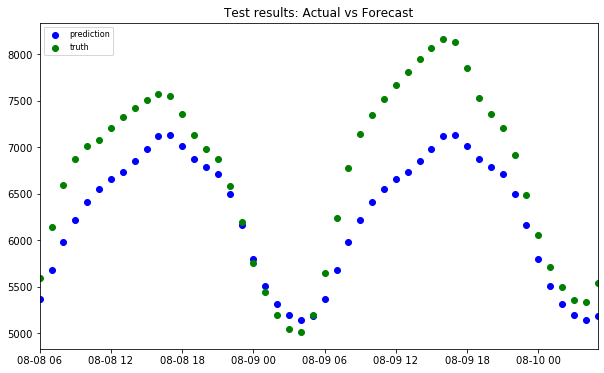

In [56]:
#$my
plt.figure(figsize=(10,6))
test_pred = plt.scatter(ts_results_all["timeStamp"], ts_results_all["predicted"], color="b")
test_test = plt.scatter(ts_results_all["timeStamp"], ts_results_all["demand"], color="g")
plt.title("Test results: Actual vs Forecast")
plt.xlim(ts_results_all["timeStamp"].min(), ts_results_all["timeStamp"].max())
plt.legend((test_pred, test_test), ("prediction", "truth"), loc="upper left", fontsize=8)
plt.show()

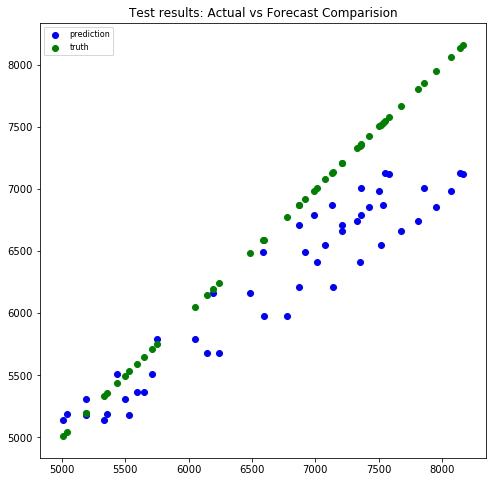

In [57]:
plt.figure(figsize=(8,8))
test_pred = plt.scatter(ts_results_all[target_column_name], ts_results_all["predicted"], color="b")
test_test = plt.scatter(ts_results_all[target_column_name], ts_results_all[target_column_name], color="g")
plt.title("Test results: Actual vs Forecast Comparision")
plt.legend((test_pred, test_test), ("prediction", "truth"), loc="upper left", fontsize=8)
plt.show()

In [58]:
mystop

NameError: name 'mystop' is not defined

## Xtra

In [ ]:
$original bits - replaced with data pipeline performed in my4_AML_0_DataSetup.ipynb
#define the target column
target_column_name = "demand"
#temporal structure
time_column_name = "timeStamp"

ts_data = Dataset.Tabular.from_delimited_files( #class azureml.data.tabular_dataset.TabularDataset
    path="https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/nyc_energy.csv"
).with_timestamp_columns(fine_grain_timestamp=time_column_name)

ts_data.take(5).to_pandas_dataframe().reset_index(drop=True)
#original automl config - in fact stayed the same due to specif format req for train ds
automl_config = AutoMLConfig(
    task="forecasting",
    primary_metric="normalized_root_mean_squared_error",
    blocked_models=["ExtremeRandomTrees", "AutoArima", "Prophet"],
    experiment_timeout_hours=0.3,
    training_data=train,
    label_column_name=target_column_name,
    compute_target=compute_target,
    enable_early_stopping=True,
    n_cross_validations=3,
    verbosity=logging.INFO,
    **automl_settings
)

#$original in predict part
X_test = test.to_pandas_dataframe().reset_index(drop=True)
y_test = X_test.pop(target_column_name).values

In [ ]:
#$xtra $my
#get info about training
#refer to https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.run.automlrun?view=azure-ml-py
remote_run.get_output(iteration=0)
remote_run.get_output(iteration=20)

remote_run.get_output(metric='normalized_root_mean_squared_error')
remote_run.get_output(metric='spearman_correlation')

#If you'd like to inspect the preprocessor(s) and algorithm (estimator) used, you can do so through Model.steps, similar to sklearn.pipeline.Pipeline.steps. 
#For instance, the code below shows how to retrieve the estimator.
estimator = fitted_model.steps[-1]
estimator
